In [1]:
import pysam
import os
from Bio import SeqIO
import pandas as pd
import tables
import h5py 
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# path to the first pass consensus
consensus_fasta = "../../data/working_directory/rough_consensus_output/labeled_consensus.fasta"
sam_path = "../../data/working_directory/rough_consensus_output/bc_consensus_aligned.sam"

In [113]:
def get_record_indexes(consensus_path):
    """
    get_record_indexes takes in a path to a labeled consensus file, and returns a list
    containing dictionaries of the start and end indicies of the unknown region of the consensus.

    Parameters:
    consensus_path: path to consensus fasta (typically labeled_consensus.fasta) as a string

    Returns:
    list of dicts of indexes.
    
    """
    list_record_indexes = []
    for record in SeqIO.parse(consensus_path, "fasta"):
        header = record.description
        match = re.search(r'BC 1: (\d+), BC 2: (\d+)', header)
        idxs = {"start":-1,"end":-1}
        if match:
            idxs["start"] = int(match.group(1))
            idxs["end"] = int(match.group(2))
        list_record_indexes.append(idxs)
    return list_record_indexes

read_indexes = get_record_indexes(consensus_fasta)[0]

In [114]:
read_indexes['start']=read_indexes['start']-1
read_indexes['end']=read_indexes['end']+2

In [115]:
read_indexes

{'start': 34, 'end': 56}

In [111]:
def load_in_data(samfile_path):
    """
    load_in_data takes in a path to a basecalled and aligned consensus samfile,
    and converts the data into a dataframe format.

    Parameters:
    sam_path: path, as str, to the basecalled and aligned consensus samfile.

    Returns:
    pandas dataframe of the relevant data. [sequence id, sequence, quality, length, reference index]
    """
    data_list = []
    with pysam.AlignmentFile(samfile_path, 'r') as samfile:
        for read in samfile:
            if (not read.is_unmapped):
                sequence_id = read.query_name
                seq = read.query_alignment_sequence
                cigar = read.cigartuples
                ref = read.reference_start
                quality = read.query_alignment_qualities
                read_dict = {'seq_id':sequence_id,
                             'sequence':seq,
                             'quality':quality,
                             'cigar':cigar,
                             'len':len(seq),
                             'ref':ref}
                #if (ref == 0):
                data_list.append(read_dict)
    df = pd.DataFrame(data_list)
    df['quality'] = df['quality'].apply(list)
    return df

loaded_df = load_in_data(sam_path)

In [112]:
loaded_df

,seq_id,sequence,quality,cigar,len,ref
0,06c3e884-20b6-43bf-a753-23bcecc6dff4,GGTCTGGTGCCACTGGTCTGCTACGAGTGATGGTATTCGACTACAC...,"[32, 31, 32, 33, 39, 41, 46, 39, 39, 37, 35, 3...","[(4, 29), (0, 35), (2, 1), (0, 54), (4, 6)]",89,0
1,04ca945c-8826-43a7-8d30-4bed3cf40088,GGTCTGGTGCCACTGGTCTATGAGTGATGGTATTGAACATTACTGT...,"[9, 8, 8, 10, 14, 14, 14, 23, 23, 28, 23, 18, ...","[(4, 33), (0, 17), (2, 3), (0, 15), (2, 7), (0...",80,0
2,074f2c7a-e28d-46d1-986a-6dc232af01be,GGTCTGGTGCCACTGGTCTGCTACGAGTGATGGTATTGACCTAGGC...,"[6, 5, 8, 11, 12, 20, 22, 22, 30, 26, 18, 17, ...","[(4, 11), (0, 35), (2, 1), (0, 54), (4, 29)]",89,0
3,0917a3ba-d9ce-4982-b494-18153ae174a3,GGTCTGGTGCCACTGGTCTGCTACAGTGATGGTATTGGACTAGGGC...,"[13, 13, 14, 15, 21, 21, 21, 36, 36, 36, 16, 1...","[(4, 31), (0, 24), (2, 1), (0, 65), (4, 70)]",89,0
4,092b468f-f786-4795-9279-93b670239ad5,GGTCTGGTGCCACTGGTCTGCTACGAGTGATGGTATTGGACTAGGC...,"[21, 19, 19, 24, 28, 30, 30, 30, 33, 33, 25, 2...","[(4, 10), (0, 35), (2, 2), (0, 53), (4, 28)]",88,0
...,...,...,...,...,...,...
2191,f8f9773b-e819-4214-aae7-9719ea04b31d,GGTCTGGTGCCACTGGTCTGCTACGAGTGATGGTATTGGACTAGGC...,"[14, 13, 13, 12, 12, 16, 13, 13, 14, 14, 15, 1...","[(4, 12), (0, 55), (2, 1), (0, 3), (1, 4), (0,...",93,0
2192,fa3c94d9-6e8b-4daa-a0d5-1f1521eae387,GGTCTGGTGCCACTGGTCTGCTACGAGTGATGGTATTGGACCTCAG...,"[15, 14, 13, 13, 13, 21, 21, 20, 25, 25, 9, 7,...","[(4, 13), (0, 35), (1, 1), (0, 55), (4, 36)]",91,0
2193,fb22dba8-b975-493c-b968-825902949014,TGGTGCCACTGGTCTGCTACGAGTGACTAAATTGCACTTAGGGCTC...,"[11, 22, 27, 27, 33, 31, 31, 31, 29, 24, 23, 2...","[(4, 13), (0, 26), (1, 1), (0, 1), (1, 1), (0,...",88,4
2194,fca00587-9b99-48c0-8230-c7d337a4f30f,GGTCTGGTGCCACTGGTCTGCTACGAGTGATGGTATTCAACTAGCT...,"[21, 16, 16, 17, 17, 11, 10, 10, 15, 13, 11, 1...","[(4, 28), (0, 52), (2, 4), (0, 34), (4, 9)]",86,0


In [91]:
def shift_sequence(sequence, qualities, ref, cigar):
    """
    shift_sequences takes in a sequence, corresponding quality, and reference position, and
    shifts it to align it with the proper positioning.

    Parameters:
    sequence: DNA read sequence as str.
    quality: DNA read qualities as list, same length of str.
    ref: reference position on the reference read, as int.
    cigar: the cigar string of the read, as str.

    returns:
    a touple of shifted sequence and shifted qualities.
    """
    seq = list(sequence)
    quals = qualities

    list()

    for operation in cigar:
        op_type = operation[0]
        op_length = operation[1]

        # 0 - alignment match
        # 1 - Insertion
        # 2 - deletion
        # 3 - skipped region from reference
        # 4 - soft clipping
        # 5 - hard clipping
        # 6 - padding
        # 7 - sequence match
        # 8 - sequence mismatch

    
    
    for i in range(ref):
        seq = "E"+seq
        quals.insert(0,'-1')

    return seq, quals

In [92]:
def trim(vals, i, j):
    if type(vals) == type(""):
        return ''.join(list(vals)[i:j])
    elif type(vals) == type([]):
        return vals[i:j]

In [93]:
def format_sequences(reads_df, indexes):
    """
    format_sequences takes in a dataframe of data previously exported from a sam file, and 
    indexes of the start and end of an unknown region, and returns the reads and quality scores for those segments.

    Parameters:
    reads_df: dataframe containing [sequence id, sequence, quality, length, reference index]
    indexes: a dictionary {"start", "end"} that contains the start and end indexes of an unknown region.
    """

    #step 1: remedying insertions, deletions and alignment
    l_df = reads_df.copy()
    l_df['shift'] = l_df.apply(lambda x: shift_sequence(x['sequence'], x['quality'], x['ref'], x['cigar']), axis = 1)
    new_col_list = ['shifted_seq','shifted_qual']
    for n,col in enumerate(new_col_list):
        l_df[col] = l_df['shift'].apply(lambda x: x[n])

    l_df = l_df.drop('shift',axis=1)

    #Step 2, trimming off the ends
    trim_sequence_series = l_df.apply(lambda x: trim(x['sequence'], indexes["start"], indexes["end"]), axis = 1)
    trim_qual_series = l_df.apply(lambda x: trim(x['quality'], indexes["start"], indexes["end"]), axis = 1)

    #Step 3: formatting to an puput dataframe
    out_df = pd.DataFrame(columns = ['id', 'seq', 'qual'])
    out_df['id']=l_df['seq_id']
    out_df['seq']=trim_sequence_series
    out_df['qual']=trim_qual_series
    return out_df

In [94]:
formatted_df = format_sequences(loaded_df, read_indexes)

In [95]:
seq_coordinate_df = pd.DataFrame(formatted_df['seq'].apply(list).to_list())
seq_coordinate_df

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,G,G,T,C,T,G,G,T,G,C,...,C,A,C,A,C,C,None,None,None,None
1,G,G,T,C,T,G,G,T,G,C,...,None,None,None,None,None,None,None,None,None,None
2,G,G,T,C,T,G,G,T,G,C,...,C,A,C,A,C,C,None,None,None,None
3,G,G,T,C,T,G,G,T,G,C,...,C,A,C,A,C,C,None,None,None,None
4,G,G,T,C,T,G,G,T,G,C,...,A,C,A,C,C,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,G,G,T,C,T,G,G,T,G,C,...,C,A,A,C,C,A,C,A,C,C
2192,G,G,T,C,T,G,G,T,G,C,...,A,C,C,A,C,A,C,C,None,None
2193,T,G,G,T,G,C,C,A,C,T,...,A,C,A,C,C,None,None,None,None,None
2194,G,G,T,C,T,G,G,T,G,C,...,A,C,C,None,None,None,None,None,None,None


In [96]:
quality_coordinate_df = pd.DataFrame(formatted_df['qual'].to_list())

In [97]:
quality_coordinate_df

,0,1,2,3,4,5,6,7,8,9,...,83,84,85,86,87,88,89,90,91,92
0,32,31,32,33,39,41,46,39,39,37,...,11.0,15.0,14.0,13.0,12.0,8.0,NaN,NaN,NaN,NaN
1,9,8,8,10,14,14,14,23,23,28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,5,8,11,12,20,22,22,30,26,...,36.0,39.0,39.0,37.0,27.0,26.0,NaN,NaN,NaN,NaN
3,13,13,14,15,21,21,21,36,36,36,...,44.0,34.0,37.0,35.0,33.0,30.0,NaN,NaN,NaN,NaN
4,21,19,19,24,28,30,30,30,33,33,...,42.0,42.0,42.0,37.0,37.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,14,13,13,12,12,16,13,13,14,14,...,47.0,46.0,40.0,42.0,40.0,40.0,37.0,36.0,19.0,19.0
2192,15,14,13,13,13,21,21,20,25,25,...,50.0,40.0,44.0,50.0,37.0,41.0,36.0,37.0,NaN,NaN
2193,-1,-1,-1,-1,11,22,27,27,33,31,...,26.0,25.0,25.0,26.0,35.0,27.0,26.0,26.0,28.0,NaN
2194,21,16,16,17,17,11,10,10,15,13,...,15.0,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
def calc_base_probs(sequence_coordinates):
    """
    base_probs takes in a dataframe of base sequence coordinates and calculates the
    numerical probability of each base at each position by the number of occurences.

    Parameters:
    sequence_coordinates: A pandas dataframe where each row is a read, and each
                          column is a base position. Thus, each cell should have
                          a single base, as a string.

    Returns:
    a dataframe containing statistical likelyhoods of each base at a given position,
    with base positons as columns and base id's as rows. 
    """
    base_options = ['A', 'G', 'C', 'T', '-']

    list_of_prob_dicts = []
    
    for column in list(sequence_coordinates.columns):
        
        counts_dict = sequence_coordinates[column].value_counts().to_dict()

        for option in base_options:
            if option not in counts_dict:
                counts_dict[option]=0
        
        total = sum(counts_dict.values(), 0.0)

        print(total)
        probs_dict = {key: value / total for key, value in counts_dict.items()}
        list_of_prob_dicts.append(probs_dict)

    return_df = pd.DataFrame(list_of_prob_dicts)
    
    
    return return_df
    
base_probs_df = calc_base_probs(seq_coordinate_df)

2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2196.0
2194.0
2194.0
2191.0
2189.0
2180.0
2161.0
2132.0
2076.0
1960.0
1796.0
1581.0
1259.0
728.0
272.0
88.0
36.0


In [99]:
base_probs_df

,G,T,C,A,-
0,0.933515,0.057832,0.008652,0.000000,0.0
1,0.894809,0.095173,0.010018,0.000000,0.0
2,0.056466,0.857013,0.086521,0.000000,0.0
3,0.018670,0.141166,0.839709,0.000455,0.0
4,0.144353,0.855647,0.000000,0.000000,0.0
...,...,...,...,...,...
88,0.000000,0.000000,0.812550,0.187450,0.0
89,0.000000,0.000000,0.913462,0.086538,0.0
90,0.000000,0.000000,0.889706,0.110294,0.0
91,0.000000,0.000000,0.954545,0.045455,0.0


In [100]:
def shannon_entropies(base_probs):
    tmp_df = base_probs.copy()

    base_options = ['A', 'G', 'C', 'T', '-']
    
    for column in list(tmp_df.columns):
        base_ser = tmp_df[column]
        tmp_df[column] = base_ser*np.log2(base_ser)

    entropy = tmp_df.sum(axis=1)*-1

    return entropy
    
shentropy_series = shannon_entropies(base_probs_df)

/home/sebastian/.conda/envs/xna_seq/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


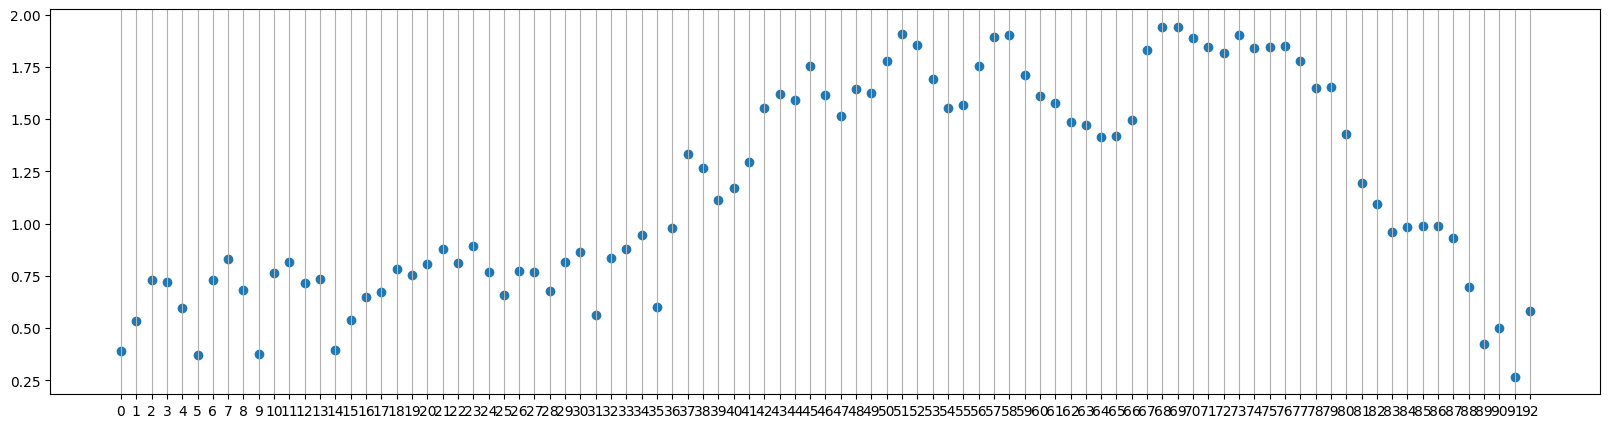

In [101]:
fig, ax = plt.subplots(1, 1, figsize = (20, 5))

base_indexes = list(shentropy_series.index)
for i in base_indexes:
    base_indexes[i] = str(base_indexes[i])

ax.scatter(x=base_indexes, y=shentropy_series)
ax.grid(axis="x")

In [32]:
def threemer(x1, x2, x3):
    mean = (x1+x2+x3 / 3)
    std = np.sqrt(((x1-mean)**2 + (x2-mean)**2 + (x3-mean)**2) / 3)
    return mean, std

In [13]:
def threemer_t_test(toup1, toup2):
    t = None
    if (toup1 != None):
        if (toup2 != None):
            t = (toup1[0] - toup2[0])/np.sqrt((toup1[1]**2 / 3) + (toup2[1]**2  /3))
    return t

In [23]:
def find_ttest_threemers(qual_coords):
    """
    find_ttest_threemers takes in a quality coordinate dataframe (x being base, y being read number)
    and then finds the t-test values for each read in that dataset.

    Parameters:
    qual_coords: dataframe of base read qualities with column being read and row being base.

    Returns:
    a dataframe of threemers.
    """
    trans_qual_cord = qual_coords.T.copy()
    
    threemers = []
    for column in list(trans_qual_cord.columns):
        tmp = pd.DataFrame(columns=['base','up','down'])
        
        tmp['base'] = trans_qual_cord[column]
        tmp['up'] = trans_qual_cord[column].shift(-1)
        tmp['down'] = trans_qual_cord[column].shift(1)
    
        tmp['m_s_1']= tmp.apply(lambda x: threemer(x['base'], x['up'], x['down']), axis = 1)
    
        tmp['m_s_2'] = tmp['m_s_1'].shift(-1)
        
        threemer_ts = tmp.apply(lambda x: threemer_t_test(x['m_s_1'], x['m_s_2']), axis = 1)
        threemers.append({"read":column,"t_values":list(threemer_ts[1:-2])})
    return pd.DataFrame(threemers)

In [29]:
three_t = find_ttest_threemers(quality_coordinate_df)

In [31]:
t_coordinate_df = pd.DataFrame(three_t['t_values'].to_list())

In [33]:
sums = []
means = []
stds = []
col_list = list(t_coordinate_df.columns)
string_columns = []
for column in col_list:
    sum = t_coordinate_df[column].sum()
    mean = t_coordinate_df[column].mean()
    std = t_coordinate_df[column].std()
    sums.append(sum)
    means.append(mean)
    stds.append(std)
    string_columns.append(str(column))

Text(0, 0.5, 'mean t-test score')

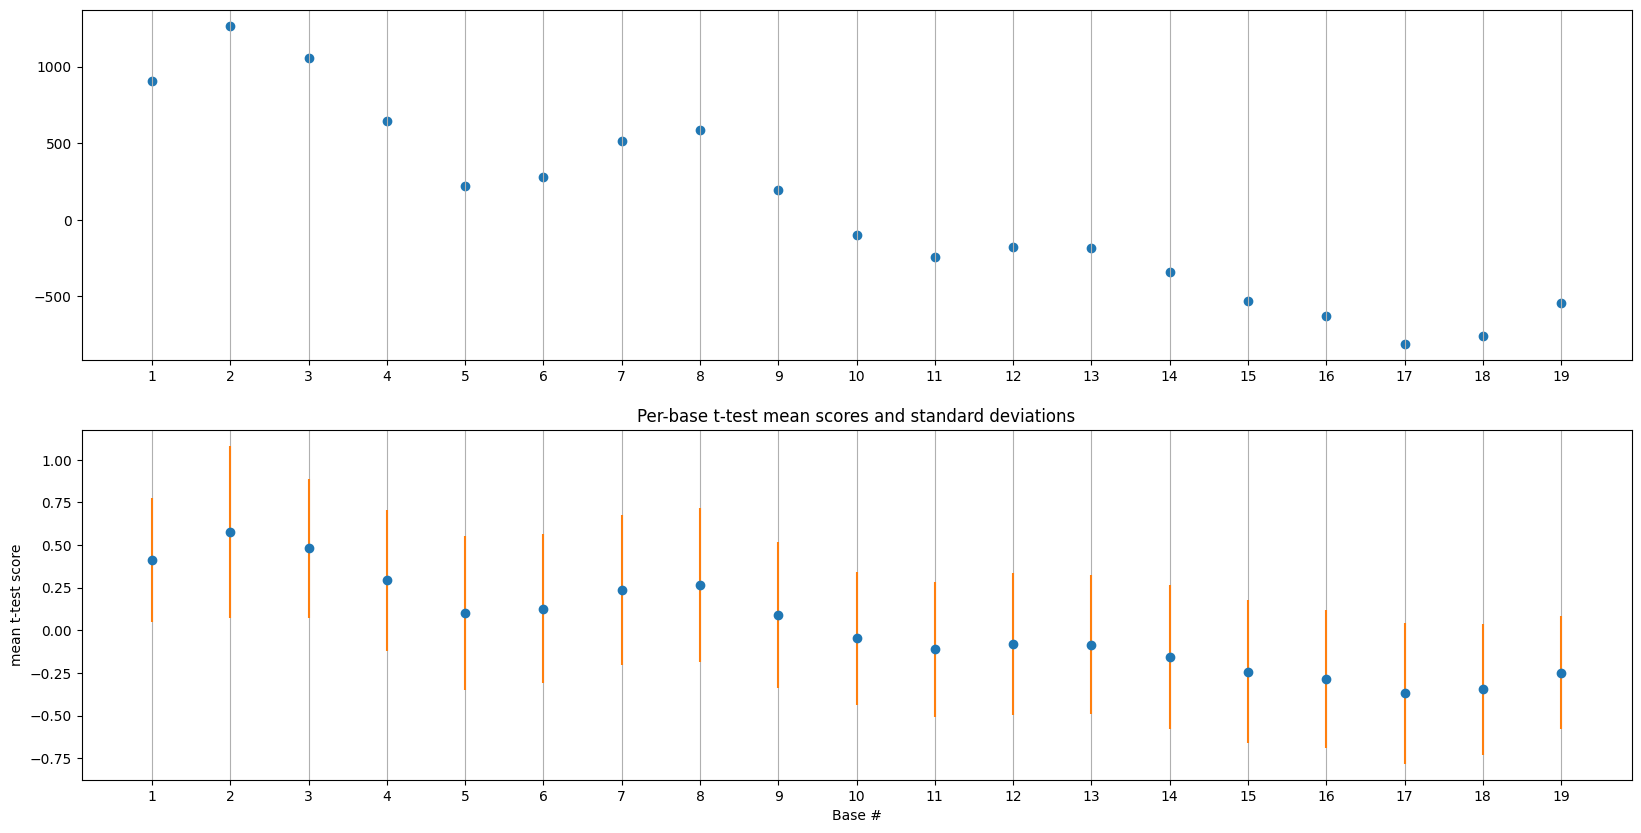

In [36]:
fig, ax = plt.subplots(2, 1, figsize = (20, 10))
ax[0].scatter(string_columns, sums)
ax[0].grid(axis="x")

ax[1].grid(axis="x")
ax[1].errorbar(string_columns, means, np.array(stds), linestyle='None', marker='o', ecolor="tab:orange")
ax[1].set_title("Per-base t-test mean scores and standard deviations")
ax[1].set_xlabel("Base #")
ax[1].set_ylabel("mean t-test score")